<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 339 to 788
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Grain density (g cm-3)          127 non-null    float64
 1   Total porosity (-)              127 non-null    float64
 2   Connected porosity (-)          127 non-null    float64
 3   Intrinsic permeability (m2)     127 non-null    float64
 4   Gas apparent permeability (m2)  127 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
100.0


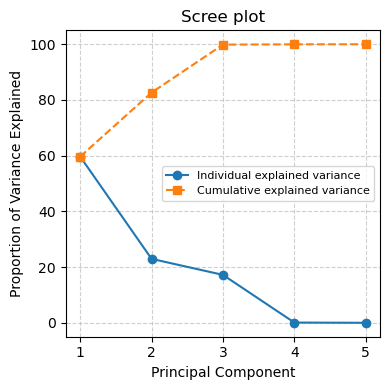

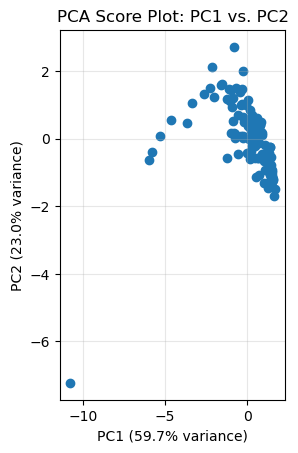

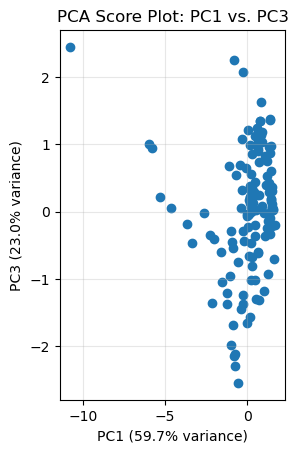

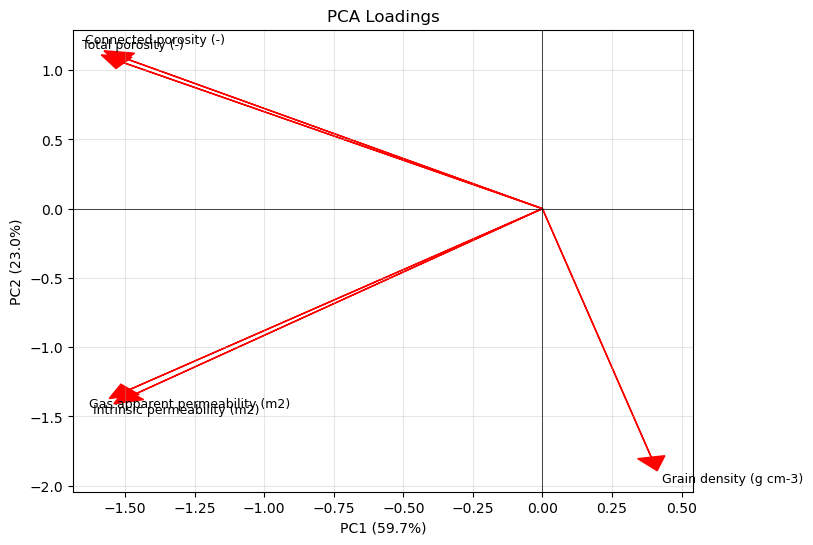

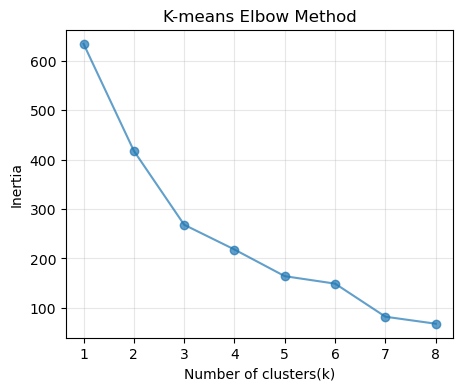

                                     PC1       PC2       PC3       PC4  \
Grain density (g cm-3)          0.130381 -0.598065 -0.790762  0.002842   
Total porosity (-)             -0.501328  0.350938 -0.350706 -0.708436   
Connected porosity (-)         -0.498384  0.360545 -0.352284  0.705237   
Intrinsic permeability (m2)    -0.489023 -0.447206  0.255431  0.023121   
Gas apparent permeability (m2) -0.494106 -0.434942  0.249705 -0.014686   

                                     PC5  
Grain density (g cm-3)          0.002530  
Total porosity (-)             -0.025214  
Connected porosity (-)          0.012515  
Intrinsic permeability (m2)    -0.703622  
Gas apparent permeability (m2)  0.710012  


In [51]:
# Quantifying Sedimentary Process Domains Using Multivariate Facies Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

file = "Valgardur_Database.csv"

df = pd.read_csv(file)

# Drop columns with excessive missing information
df_clean = df.drop(columns=['Liquid apparent permeability (m2)', 'Thermal conductivity (W m-1 K-1)'])

# Drop rows with missing data in the remaining columns so PCA accounts for all 5 components
df_clean = df_clean.dropna()

# Inspect cleaned data
df_clean.info()
df_clean.head(5)

# Standardize all data before a PCA - use sklearn
scaler = StandardScaler()
X_std = scaler.fit_transform(df_clean)

# Find covariance matrix and calculate eigenvalues and eigenvectors
cov_matrix = np.cov(X_std.T)
eigvals, eigvecs = np.linalg.eig(cov_matrix)

# Now order my eigenvalues from greatest to smallest with their corresponding eigenvectors
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Calculate variance explained 
var_exp = (eigvals / np.sum(eigvals)) * 100
print(np.sum(var_exp)) # Should be 100 to make sure we have all our data spoken for

# Now let's make a skree plot to show that we have rational to plot our basis of PC1 = x axis and PC2 = y axis
cum_var_exp = np.cumsum(var_exp) # Gives us a running total as we add up each number in the array

# Scree plot
plt.figure(figsize=(4,4))
plt.plot(range(1, len(var_exp)+1), var_exp, 'o-', label='Individual explained variance') # Use range() function cause we don't have y values and want it to just count up from 1 to the # of components we have
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, 's--', label='Cumulative explained variance')

# Labels and formatting
plt.title('Scree plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, len(var_exp) + 1))
plt.grid(True, linestyle = '--', alpha=0.6)
plt.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.show()

# Now let's get our data back and plot it onto our PCs
PC1 = eigvecs[:, 0] # First column = PC1
PC2 = eigvecs[:, 1] # Second column = PC2
PC3 = eigvecs[:, 2] # Third column = PC3
PC4 = eigvecs[:, 3] # Fourth column = PC4
PC5 = eigvecs[:, 4] # Fifth column = PC5
scores_PC1 = X_std @ PC1
scores_PC2 = X_std @ PC2
scores_PC3 = X_std @ PC3
scores_PC4 = X_std @ PC4
scores_PC5 = X_std @ PC5

# Now we plot PC1 v PC2
plt.subplot(1, 2, 1)
plt.scatter(scores_PC1,scores_PC2)
plt.xlabel(f'PC1 ({var_exp[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({var_exp[1]:.1f}% variance)')
plt.title('PCA Score Plot: PC1 vs. PC2')
plt.grid(True, alpha=0.3)
plt.show()
# Also perhaps try PC1 v PC3 since PC2 accounts for just a smidge more variance than PC3
plt.subplot(1,2,2)
plt.scatter(scores_PC1,scores_PC3)
plt.xlabel(f'PC1 ({var_exp[0]:.1f}% variance)')
plt.ylabel(f'PC3 ({var_exp[1]:.1f}% variance)')
plt.title('PCA Score Plot: PC1 vs. PC3')
plt.grid(True, alpha=0.3)
plt.show()

# Biplot showing variable contributions - This shows us what is positively correlated (pointing together), negatively (~180°), and uncorrelated (~90%)
plt.figure(figsize=(8, 6))
for i, var in enumerate(df_clean):
    plt.arrow(0, 0, eigvecs[i, 0]*3, eigvecs[i, 1]*3, 
              head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.text(eigvecs[i, 0]*3.3, eigvecs[i, 1]*3.3, var, fontsize=9)

plt.xlabel(f'PC1 ({var_exp[0]:.1f}%)')
plt.ylabel(f'PC2 ({var_exp[1]:.1f}%)')
plt.title('PCA Loadings')
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.show()

# K-MEANS CLUSTERING
# combine scores in a matrix 
X_pca = np.column_stack((scores_PC1, scores_PC2, scores_PC3))

# Import sklearn stuff for Kmeans
from sklearn.cluster import KMeans
k_values = np.arange(1,9)
inertias = np.array([KMeans(n_clusters=k, random_state=42).fit(X_pca).inertia_ for k in k_values])
# Now plot our range of k values against inertia and k will = where the elbow would be 
plt.figure(figsize=(5,4))
plt.plot(k_values,inertias,'o-', alpha=0.7)
plt.xlabel('Number of clusters(k)')
plt.ylabel('Inertia')
plt.title('K-means Elbow Method')
plt.grid(alpha=0.3)
plt.show()

# This shows us which characteristics of our samples are affected by each PC (look for high neg or pos), we then go in and interpret what the PCs represent 
# (e.g., If PC1 has high positive loadings on grain size fractions and permeability, PC1 likely represents sorting or energy of depositional environment; coarser -> higher energy)
# (e.g., If PC2 has strong loadings on porosity and grain density, PC2 might represent diagenetic compaction or cementation)
# (e.g., If PC3 emphasizes mineral composition (say, high feldspar or quartz content))
loadings = pd.DataFrame(eigvecs, index=df_clean.columns, columns=[f'PC{i+1}' for i in range(len(eigvals))])
print(loadings)


In [ ]:
# PS01 - 4.1.3

# Given
d13C_v = -6  
epsilon = 25  
f_org = 0.2  # fraction of organic carbon burial 

# Method 1: Simple steady-state
d13C_c_simple = d13C_v + f_org * epsilon
print(f"Steady-state δ13C_c = {d13C_c_simple}‰")

# Method 2: Modulated by spreading rate
HSR_data = df2['Mean Length-Averaged Half Spreading Rate (mm/yr)']
HSR_modern = 24  # mm/yr

# Higher HSR -> more volcanic input -> more negative δ13C
volcanic_factor = HSR_data / HSR_modern
d13C_baseline = 1.0  # Modern ocean average (adjust to match your data)

# Calculate shift from baseline
d13C_shift = (volcanic_factor - 1) * (d13C_v - d13C_baseline) * 0.5  # Scale factor
d13C_c_model = d13C_baseline + d13C_shift

# Observed data
d13C_observed = df2['d13C of Benthic Foraminifera (per mil)']

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(df2['Age'], d13C_observed, 'o-', c='blue', linewidth=2, 
         markersize=4, label='Observed δ¹³C')
plt.plot(df2['Age'], d13C_c_model, '-', c='red', linewidth=2, 
         label='Model δ¹³C (HSR-driven)')
plt.axhline(d13C_c_simple, color='gray', linestyle='--', 
           label=f'Steady-state ({d13C_c_simple}‰)')
plt.xlabel('Age (Ma)')
plt.ylabel('δ¹³C (‰)')
plt.title('Model vs Observed δ¹³C', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Check correlation
print(f"\nCorrelation between HSR and observed δ13C: {np.corrcoef(HSR_data, d13C_observed)[0,1]:.3f}")